<a href="https://colab.research.google.com/github/Camicb/practice/blob/main/Predicting_Housing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
#!pip install -U scikit-learn
#!pip install pandas

In [2]:
#! pip install pycaret

In [3]:
#!pip install scikit-optimize
#!pip install optuna
#!pip install tune-sklearn ray[tune]
#!pip install hyperopt

In [4]:
# Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn import set_config
from sklearn import linear_model
from sklearn.linear_model import ElasticNet


In [5]:
# Data info and sources : https://github.com/Camicb/handson-ml2/blob/master/datasets/housing/README.md

# Loading the data
housing = pd.read_csv('https://raw.githubusercontent.com/Camicb/handson-ml2/master/datasets/housing/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Notes:
The  median income attribute has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). The housing median age and the median house value were also capped.

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
profile = ProfileReport(housing, html={'style': {'full_width': True, 'primary_color': '#30b6c2'}},  samples=None, missing_diagrams=None, interactions=None)
profile.to_file("report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

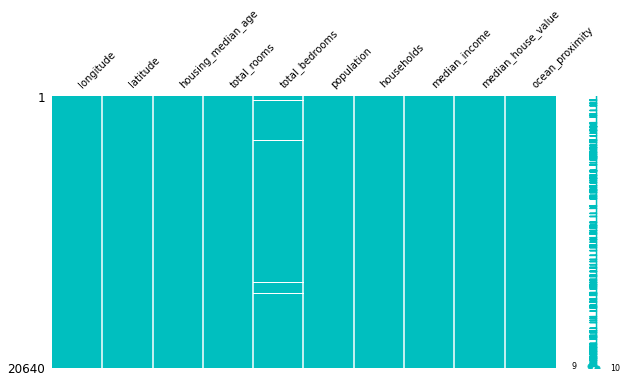

In [8]:
# Visualization of missing values
msno.matrix(housing, figsize=(10,5), fontsize=10, color=(0.0, 0.75, 0.75)) 

In [9]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing=housing.drop(['total_rooms', 'households', 'total_bedrooms', 'population'], axis=1)

In [10]:
housing.head()

,longitude,latitude,housing_median_age,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,2.181467


In [11]:
housing['ocean_proximity']=housing['ocean_proximity'].replace({'<1H OCEAN': '1H OCEAN'}) # deleting the < sign

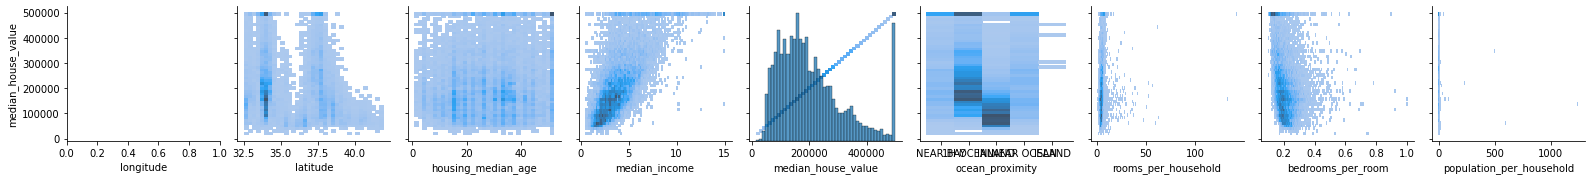

In [12]:
sns.pairplot(data=housing, x_vars=housing.columns, y_vars='median_house_value', kind="hist")

In [13]:
# Selecting the variables 
X=housing.drop(['median_house_value'], axis=1)
y=housing["median_house_value"]

# Converting the median income from a continuous numerical attribute to a categorical attribute 
y_cat= pd.cut(housing["median_house_value"], [0., 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000], right=False)

#Spliting the data with stratification into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1, stratify=y_cat)

# Converting the median income from y_train to a categorical  attribute 
y_train_cat= pd.cut(y_train, [0., 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000], right=False)

#Spliting the training data into a new training and validation sets 
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.15, random_state=2, stratify=y_train_cat)


In [14]:
# Preprocesing with pipelines

#num_var = make_column_selector(dtype_include=['int64', 'float64'])
#cat_var = make_column_selector(dtype_include=['object','category','bool'])

#numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
#categorical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'most_frequent')), ('encoder', OneHotEncoder())])

#preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_var), ('cat', categorical_transformer, cat_var)])

#set_config(display='diagram')
#preprocessor

In [15]:
train=pd.concat([X_train, y_train], axis=1)
val=pd.concat([X_val, y_val], axis=1)

In [16]:
# pycaret
from pycaret.regression import *
reg = setup(data= train,
            target= 'median_house_value',
            test_data=val,
            normalize=True,
            transformation=True,
            feature_selection=True,
            feature_selection_threshold=0.9, 
            feature_selection_method='boruta')

,Description,Value
0,session_id,8151
1,Target,median_house_value
2,Original Data,"(14912, 9)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(14912, 8)"


In [18]:
models=compare_models(include=['catboost','lightgbm', 'xgboost', 'rf'], sort='RMSE')
# I commpared all the models inicially and later exclude the ones with very poor performance

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,28845.3070,1.943130e+09,44043.7738,0.8535,0.2161,0.1591,4.419
lightgbm,Light Gradient Boosting Machine,30422.6250,2.085420e+09,45631.2142,0.8427,0.2257,0.1705,0.204
xgboost,Extreme Gradient Boosting,30433.9863,2.143671e+09,46261.2680,0.8384,0.2267,0.1679,4.830
rf,Random Forest Regressor,32077.5504,2.430479e+09,49267.6334,0.8167,0.2352,0.1769,6.530


In [33]:
catboost = create_model('catboost') # tuning the model increase error

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,28752.4452,1.799788e+09,42423.9136,0.8642,0.2136,0.1624
1,29745.8521,2.176834e+09,46656.5517,0.8316,0.2167,0.1582
2,28174.6236,2.026238e+09,45013.7525,0.8455,0.2229,0.1595
3,28278.6898,1.813490e+09,42585.0930,0.8639,0.2021,0.1498
4,29855.8216,2.125265e+09,46100.5921,0.8301,0.2181,0.1596
5,27830.5748,1.671618e+09,40885.4269,0.8684,0.2224,0.1681
6,28739.8918,1.903722e+09,43631.6628,0.8669,0.2039,0.1518
7,28643.6248,1.863228e+09,43165.1217,0.8592,0.2181,0.1596
8,30087.8827,2.141275e+09,46273.9138,0.8403,0.2278,0.1675
9,28343.6637,1.909839e+09,43701.7105,0.8652,0.2153,0.1544


In [34]:
print(catboost)

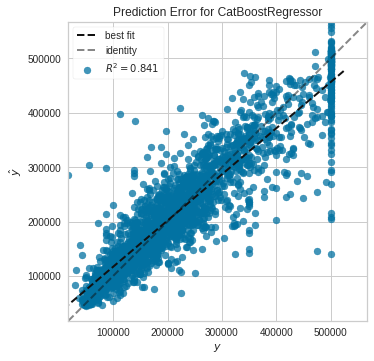

In [37]:
plot_model(catboost, plot = 'error')

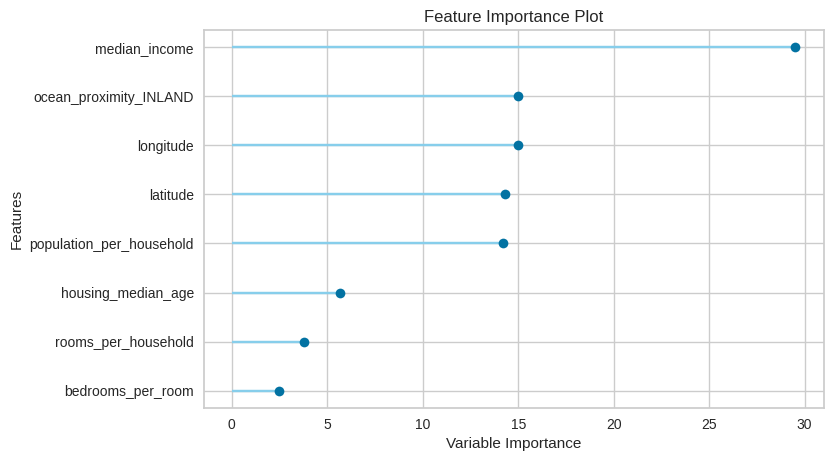

In [39]:
plot_model(catboost, plot='feature')